## This notebook is to extract the events from the donations dataframe along with related attributes

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
df = pd.read_pickle('out/21/donations.pkl')

In [33]:
df.columns

Index([u'activity_date', u'city', u'fund', u'batch_num', u'amount_initial',
       u'amount_cleanup', u'zipcode', u'longitude', u'sales', u'county',
       u'charitable', u'amount', u'state', u'donor_id', u'timezone',
       u'latitude', u'appeal', u'activity_year', u'activity_month',
       u'activity_dow', u'activity_ym', u'activity_yq', u'activity_ymd',
       u'county_norm', u'census_region_name', u'state_name', u'is_service',
       u'channel', u'campaign_location_id', u'is_location_center',
       u'campaign_month_id', u'is_month_center'],
      dtype='object')

### We have 91 appeal codes that are for events
#### These break down into 125 events since appeal codes can be re-used

In [34]:
df[(df.is_service==True)].appeal.nunique()

155

In [35]:
# We will only consider services for this step, so limit what we need
dfs = df[df.is_service==True]
del df

In [36]:
events_by_attendance = dfs\
    .groupby(['appeal', 'campaign_location_id', 'campaign_month_id'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .rename(columns={0: 'transaction_count'})

In [37]:
events_by_amount = dfs\
    .groupby(['appeal', 'campaign_location_id', 'campaign_month_id', ])\
    .amount\
    .sum()\
    .to_frame()\
    .reset_index()\
    .rename(columns={0: 'amount'})

### Histogram plots

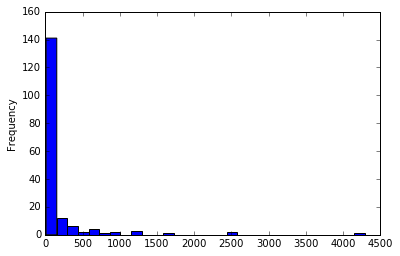

In [38]:
events_by_attendance[events_by_attendance.transaction_count > 10].transaction_count.plot(kind='hist', bins=30)

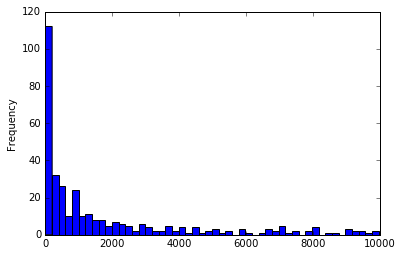

In [39]:
events_by_amount.amount[events_by_amount.amount < 10000].plot(kind='hist', bins=50)

### Check for data correctness

In [40]:
dfs[(dfs.appeal=='Event_TollywoodThriller')].shape

(161, 32)

In [41]:
dfs[(dfs.appeal=='Event_TollywoodThriller')]\
    .groupby(['appeal', 'campaign_location_id', 'campaign_month_id']).size()

appeal                   campaign_location_id  campaign_month_id
Event_TollywoodThriller  0                     0                    48
                                               1                    41
                                               2                    33
                                               3                    39
dtype: int64

In [42]:
events_by_attendance[events_by_attendance.appeal=='Event_TollywoodThriller']

,appeal,campaign_location_id,campaign_month_id,transaction_count
350,Event_TollywoodThriller,0,0,48
351,Event_TollywoodThriller,0,1,41
352,Event_TollywoodThriller,0,2,33
353,Event_TollywoodThriller,0,3,39


In [43]:
dfs[(dfs.appeal=='Event_TollywoodThriller')]\
    .groupby(['appeal', 'campaign_location_id', 'campaign_month_id']).amount.sum()

appeal                   campaign_location_id  campaign_month_id
Event_TollywoodThriller  0                     0                    3781
                                               1                    5054
                                               2                    6854
                                               3                    5415
Name: amount, dtype: int64

In [44]:
events_by_amount[events_by_amount.appeal=='Event_TollywoodThriller']

,appeal,campaign_location_id,campaign_month_id,amount
350,Event_TollywoodThriller,0,0,3781
351,Event_TollywoodThriller,0,1,5054
352,Event_TollywoodThriller,0,2,6854
353,Event_TollywoodThriller,0,3,5415


### Filter the data - we will consider only the events with atleast 10 transactions  - which results in 70 events

In [45]:
events_by_attendance[events_by_attendance.transaction_count >= 10].shape

(178, 4)

In [46]:
events_by_attendance[events_by_attendance.transaction_count < 10].transaction_count.sum()

610L

In [47]:
## Trim the event attendance data to atleast 20 transactions and merge with the other dataframe to get the amounts
events = events_by_attendance[events_by_attendance.transaction_count >= 10]\
.merge(events_by_amount, how='left', on=['appeal','campaign_location_id','campaign_month_id'])

In [48]:
# Merge with the original dataframe to get the month centers
events = events.merge(
    dfs[(dfs.is_month_center==True)]\
    [['appeal', 'campaign_month_id', 'activity_year', 'activity_month', 'activity_ym']],
    how='left', on=['appeal', 'campaign_month_id']).drop_duplicates()

# Merge with the original dataframe to get the location centers
events = events.merge(
    dfs[(dfs.is_location_center==True)]\
    [['appeal', 'campaign_location_id', 'county', 'state']],
    how='left', on=['appeal', 'campaign_location_id']).drop_duplicates()

In [49]:
# Sanity check what we got thus far
events[events.appeal == 'Event_TollywoodThriller']

,appeal,campaign_location_id,campaign_month_id,transaction_count,amount,activity_year,activity_month,activity_ym,county,state
8727,Event_TollywoodThriller,0,0,48,3781,2014,11,201411,King,WA
8773,Event_TollywoodThriller,0,1,41,5054,2012,12,201212,King,WA
8819,Event_TollywoodThriller,0,2,33,6854,2009,8,200908,King,WA
8865,Event_TollywoodThriller,0,3,39,5415,2011,7,201107,King,WA


In [50]:
dfs[(dfs.is_location_center==True) & (dfs.appeal=='Event_TollywoodThriller')]\
    [['county', 'state']].drop_duplicates()

,county,state
68858,King,WA


In [51]:
dfs[(dfs.is_month_center==True) & (dfs.appeal=='Event_TollywoodThriller')]\
    [['activity_year', 'activity_month']].drop_duplicates()

,activity_year,activity_month
68858,2014,11
68966,2009,8
70754,2012,12
71529,2011,7


### Understand the data

We had events in a total of 13 different states.  
California had the highest number of events (33). Washington has the next highest number of events (11).  
The events were more or less distributed throughout the year.  
March 2014 was by far the busiest year/month for the organization (8 events).  
2014 was the busiest year in terms of number of events (22).  
Other than that, in general events are spread out quite evenly over the year across the board.  

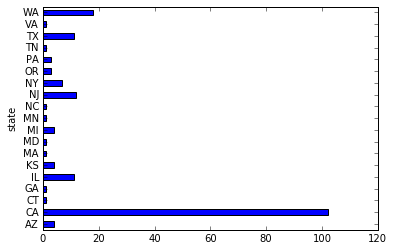

In [52]:
events.groupby('state').size().plot(kind='barh')

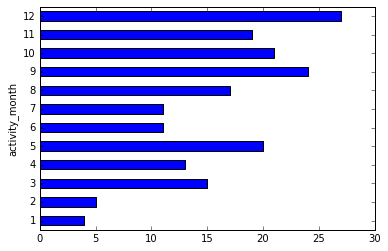

In [53]:
events.groupby('activity_month').size().plot(kind='barh')

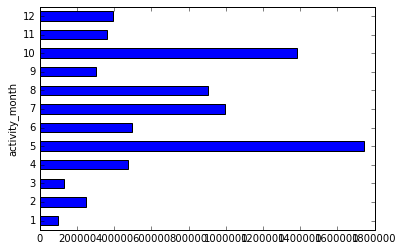

In [54]:
events.groupby('activity_month').amount.sum().plot(kind='barh')

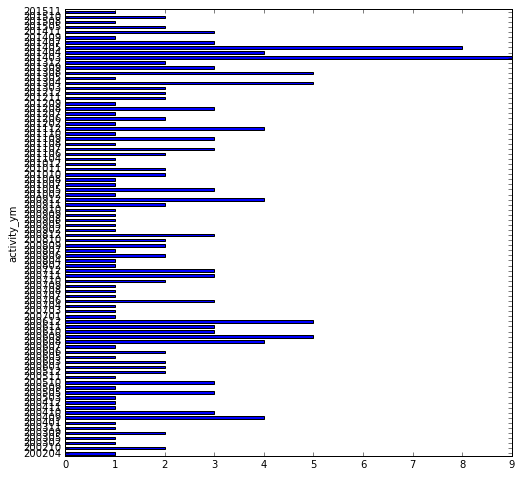

In [55]:
events.groupby('activity_ym').size().plot(kind='barh', figsize=(8,8))

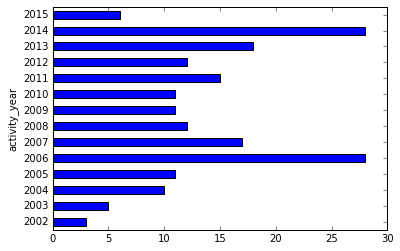

In [56]:
events.groupby('activity_year').size().plot(kind='barh')

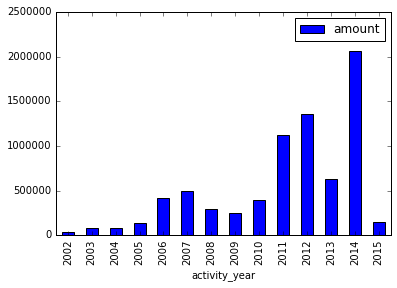

In [57]:
events.groupby(['activity_year']).agg({'amount': sum}).plot(kind='bar', legend=True)

In [58]:
pd.cut(events.transaction_count, bins=4, labels=False).shape

(187,)

### Save the data

In [59]:
!mkdir -p out/41

events\
    .reset_index()\
    .drop('index', axis=1)\
    .to_pickle('out/41/events.pkl')

In [60]:
events.head()

,appeal,campaign_location_id,campaign_month_id,transaction_count,amount,activity_year,activity_month,activity_ym,county,state
0,Banquet_GWOF,0,0,45,26548,2011,7,201107,Alameda,CA
7,Banquet_Gift Of Vision,0,0,46,9002,2010,10,201010,Alameda,CA
15,Banquet_Gujarat_CA_2008,0,0,16,8650,2008,7,200807,Santa Clara,CA
20,Banquet_Hyderabad,0,0,11,850,2015,10,201510,Santa Clara,CA
22,Banquet_Punjab_CA,0,0,65,15860,2009,11,200911,Alameda,CA
